# Overview
This notebook will examine ex-vivo histology data from the BigBrain, 3D PLI, and AHEAD brain datasets. First wewill look at morphological features in unfolded space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import nibabel as nib
import scipy
from skimage.util.shape import view_as_blocks
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob

In [2]:
source_dir = '../sourcedata/BIDS_HISTO/'
hippunfold_dir = '../hippunfold/HISTO_v1.3.0_100um/hippunfold/'

subs = ['bbhist', 'bbhist', 'bbhist2', 'bbhist2', 'pli3d', '122017', '122017', '152017', '152017']
ses = ''
hemis = ['L','R','L','R','L','L','R','L','R']
label = 'hipp'
den='unfoldiso'

# here we will generate multiple depth-wise surfaces
layers = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(layers>=0,  layers <=1))[0]
nverts = 126*254

## Morphology
As in other datasets, these are automatically generated by HippUnfold and don't need further processing

In [3]:
features = ['thickness', 'gyrification', 'curvature']
morph_dat = np.zeros([126*254,len(subs),len(features)])*np.nan
d=[]
for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        d = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl'\
                     f'_den-unfoldiso_label-{label}_{feature}.shape.gii')
        if hemis[s]=="R" and f==2:
            morph_dat[:,s,f] = -d.darrays[0].data
        else:
            morph_dat[:,s,f] = d.darrays[0].data

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


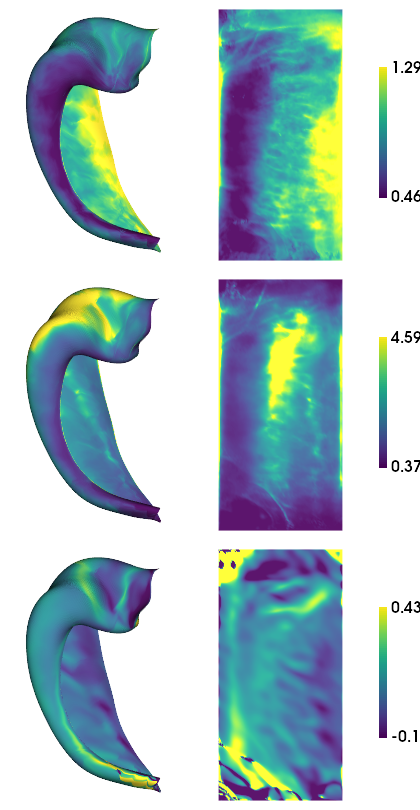

In [4]:
plotting.surfplot_canonical_foldunfold(np.mean(morph_dat,axis=1), labels=['hipp'], hemis=['L'], den=den, color_bar='right', share='row', size=[350,270], tighten_cwindow=True, embed_nb=True)

## Stain intensities
Here, we generate staining intensities on hippocampal surfaces of various depths

In [5]:
# Create surfaces at various depths
hipp_dat = np.zeros([254*126,len(layers), len(subs)])*np.nan
for s,sub in enumerate(subs):
    cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
    !{cmd}
    for l,layer in enumerate(layers):
        cmd1 = f'wb_command -surface-cortex-layer '\
            f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-unfoldiso_label-{label}_inner.surf.gii '\
            f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-unfoldiso_label-{label}_outer.surf.gii '\
            f'{layer} '\
            f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}.surf.gii'
        !{cmd1}
        cmd2 = f'wb_command -volume-to-surface-mapping '\
            f'{source_dir}/sub-{sub}/anat/sub-{sub}_hemi-{hemis[s]}.nii.gz '\
            f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}.surf.gii '\
            f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}_intensity-default.shape.gii '\
            f'-trilinear'
        !{cmd2}
        gii = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}_intensity-default.shape.gii')
        hipp_dat[:,l,s] = gii.darrays[0].data

In [ ]:
# add extra modalities from AHEAD
ahead_additional_modalities =  ['Bieloschowsky-interpolated', 'calbindin-interpolated', 'calretinin-interpolated', 'parvalbumin-interpolated', 'thionin-interpolated', 'MRI-proton-density', 'MRI-quantitative-R1', 'MRI-quantitative-R2star']
for s in [5,6,7,8]:
    for m,modality in enumerate(ahead_additional_modalities):
        vol = np.zeros((hipp_dat.shape[:2]))
        for f in range(len(layers)):
            cmd2 = f'wb_command -volume-to-surface-mapping '\
                f'{source_dir}/sub-{sub}/anat/sub-{sub}_{modality}.nii.gz '\
                f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}.surf.gii '\
                f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}_intensity-{modality}.shape.gii '\
                f'-enclosing'
            !{cmd2}
            gii = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/layer-{layer}_intensity-{modality}.shape.gii')
            vol[:,f] = gii.darrays[0].data
        hipp_dat = np.concatenate((hipp_dat, np.expand_dims(vol,axis=2)), axis=2)

In [ ]:
# inspect 
plotting.surfplot_canonical_foldunfold(np.nanmean(hipp_dat[:,gm,:15],axis=1), labels=['hipp'], hemis=['L'], den=den, size=[350,270], tighten_cwindow=True, embed_nb=True)

In [ ]:
np.save("../checkpoints/struct-HISTO-unproc",hipp_dat)

## Preprocessing
Clearly these images will need some preprocessing to account for issues like missing data, impofect alignment between AHEAD stains, and imperfect surfaces
### Missing data
For this, we will set all background values (sometimes 0, sometimes an integer like 2 or -1) to NaN. Then we will find outliers and also set them to NaN. Then we will dilate the mask of NaNs, because some edge cases are not exactly 0, but are not plausible values either. Then, we will interpolate the NaNs (linear) and extrapolate any remaining values outside the convex hull (nearest)
### Alignment method
Here we develop a tool to depth-wise or laminar align profiles, since the grey matter boundaries may not be perfect. We use only translations, and maximize the correlation between each profile and the average (either over the whole image or over image patches). I think the patch-wise solution is working best, so we'll use that.

In [ ]:
hipp_dat = np.load("../checkpoints/struct-HISTO-unproc.npy")

In [ ]:
def fill_missing(sd):
    sd[np.isin(sd, [-1,0,1,2])] = np.nan
    # find outliers
    # sd = scipy.stats.zscore(sd, axis=None, nan_policy='omit')
    # sd[sd>4] = np.nan
    # sd[sd<-4] = np.nan
    # take edges off missing data too
    sd[np.where(scipy.ndimage.morphology.binary_dilation(np.isnan(sd), structure = np.ones((5,5,5))))] = np.nan # edge cases can be off too, so remove
    # interpolate NaNs
    good = np.where(~np.isnan(sd))
    bad = np.where(np.isnan(sd))
    fill = scipy.interpolate.griddata(good, sd[good], bad)
    sd[bad] = fill
    good = np.where(~np.isnan(sd))
    bad = np.where(np.isnan(sd))
    fill = scipy.interpolate.griddata(good, sd[good], bad, method='nearest')
    sd[bad] = fill
    return sd

In [ ]:
def patch_align(patch, maxoff=5):
    '''Aligns depth-wise profiles across a heightxwidthxdepth unfolded 3D block.
    This is done using only translations in the depth dimension, and maximizes the correlation of each depth profile to the average profile'''
    p = np.reshape(patch,[patch.shape[0]*patch.shape[1],patch.shape[2]])
    p = np.pad(p,((0,0),(maxoff,maxoff)), 'edge')
    p_mean = np.mean(p,axis=0)
    rolls = np.arange(-maxoff,maxoff+1)
    roff = np.zeros((len(p),len(rolls)))
    for o,offset in enumerate(rolls):
        p_mean_off = np.reshape(np.roll(p_mean,offset),(1,len(p_mean)))
        roff[:,o] = np.corrcoef(np.concatenate((p_mean_off,p),axis=0))[1:,0]
    rbest = np.argmax(roff,axis=1)
    for i in range(len(p)):
        p[i,:] = np.roll(p[i,:],-rolls[rbest[i]])
    return np.reshape(p[:,maxoff:-maxoff],patch.shape)

def image_patch_align(image,patchsize=(16,16,1)):
    '''Applies the above function in a patch-wise fashion'''
    patches = view_as_blocks(image,block_shape=patchsize)
    for x in range(patches.shape[0]):
        for y in range(patches.shape[1]):
            p = patches[x,y,:,:,:,0].transpose(1,2,0)
            p = patch_align(p)
            patches[x,y,:,:,:,0] = p.transpose(2,0,1)
    return image

Quick test example case to see how this is working:

In [ ]:
tdat = np.reshape(hipp_dat[:,:,0],[126,254,25])
fig, ax = plt.subplots(figsize=(32, 4))
ax.imshow(tdat[:,120].T)

In [ ]:
fig, ax = plt.subplots(figsize=(32, 4))
tdat = np.reshape(hipp_dat[:,:,0],[126,254,25])
tdat = patch_align(tdat)
ax.imshow(tdat[:,120].T)

In [ ]:
tdat = np.reshape(hipp_dat[:,:,0],[126,254,25])
tdat = np.pad(tdat,((1,1),(1,1),(0,0)),'edge') # 256x128 makes for much easier division into patches!
tdat = image_patch_align(tdat)
tdat = tdat[1:-1,1:-1,:]
fig, ax = plt.subplots(figsize=(32, 4))
ax.imshow(tdat[:,120].T)

In [ ]:
# Apply to all data, alongside normalization 
hipp_dat_clean = np.zeros(hipp_dat.shape)
for s in range(hipp_dat.shape[2]):
    sd = np.reshape(hipp_dat[:,:,s], [126,254,25])
    # missing data
    sd = fill_missing(sd)
    # profile alignment
    sd = np.pad(sd,((1,1),(1,1),(0,0)),'edge')
    sd = image_patch_align(sd)
    sd = sd[1:-1,1:-1,:]
    # normalize with interpolated data
    sd = scipy.stats.zscore(sd, axis=None)
    
    hipp_dat_clean[:,:,s] = np.reshape(sd,[nverts,25])

In [ ]:
# inspect to ensure this makes sense!
plotting.surfplot_canonical_foldunfold(np.nanmean(hipp_dat_clean[:,gm,:15],axis=1), labels=['hipp'], hemis=['L'], den=den, size=[350,270], tighten_cwindow=True, embed_nb=True)

In [ ]:
np.save("../checkpoints/struct-HISTO-proc",hipp_dat_clean)

# Analyses
This looks pretty good, so lets run some analyses. First we smooth and average within the same stains, and look at some laminar profiles. Then, we examine Microstructural Profile Covariance (MPC) and dimensionality reduction (using BrainSpace Gradients). Finally, we look at profile "moments"

In [ ]:
hipp_dat_clean = np.load("../checkpoints/struct-HISTO-proc.npy")

In [ ]:
# smooth
for s in range(hipp_dat.shape[2]):
    sd = np.reshape(hipp_dat_clean[:,:,s], [126,254,25])
    # smoothing
    sd = scipy.ndimage.gaussian_filter(sd,[1,1,0.25])    
    hipp_dat_clean[:,:,s] = np.reshape(sd,[nverts,25])

In [ ]:
# group subjects within the same modality
modalities = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'MRI-proton-density', 'MRI-quantitative-R1', 'MRI-quantitative-R2star']
modality_data = np.stack((np.nanmean(hipp_dat_clean[:,:,0:3],axis=2), hipp_dat_clean[:,:,4],np.nanmean(hipp_dat_clean[:,:,5:9],axis=2)),axis=2)
for m in range(8):
    modality_data = np.concatenate((modality_data, np.nanmean(hipp_dat_clean[:,:,(m+10):-1:4],axis=2)[:,:,None]),axis=2)
modality_data.shape

In [ ]:
plotting.surfplot_canonical_foldunfold(modality_data[:,int(len(layers)/2),:10], labels=['hipp'], hemis=['L'], den=den, size=[350,270], color_bar='right', share='row',  tighten_cwindow=True, embed_nb=True)

In [ ]:
# let's look at some laminar profiles
nsamp=15
colorcool = pl.cm.cool(np.linspace(0,1,nsamp))
colorhot = pl.cm.copper(np.linspace(0,1,nsamp))
sampAP = np.linspace(51,203,nsamp).astype('int') #NOTE: here we cut off the 20% anterior and posterior since they show a lot of noise!
sampPD = np.linspace(0,125,nsamp).astype('int')

fig, ax = plt.subplots(nrows=2, ncols=len(modalities), figsize=(48,8))
modality_data = np.reshape(modality_data,[126,254,25,11])
for s in range(len(modalities)):
    
    # first sample from Ant-Post (averaged across PD)
    for i in range(nsamp):
        ax[0,s].plot(layers,np.nanmean(modality_data[:,sampAP[i],:,s],axis=0), color=colorcool[i])
    # ax[0,s].set_ylim([-1.5,2])
    ax[0,s].vlines([0,1], ax[0,s].get_ylim()[0], ax[0,s].get_ylim()[1],'k',linestyle='dashed')
    
    # now sample from Prox-Dist (averaged across AP)
    for i in range(nsamp-1):
        ax[1,s].plot(layers,np.nanmean(modality_data[sampPD[i]:sampPD[i+1],:,:,s],axis=(0,1)), color=colorhot[i])
    # ax[1,s].set_ylim([-1.5,2])
    ax[1,s].vlines([0,1], ax[1,s].get_ylim()[0], ax[1,s].get_ylim()[1],'k',linestyle='dashed')

In [ ]:
# profiles by subfield
subfs = nib.load(f'{hippunfold_dir}/sub-{subs[0]}/surf/sub-{subs[0]}_hemi-{hemis[0]}_space-corobl_den-unfoldiso_label-hipp_atlas-histologyReference2023_subfields.label.gii').darrays[0].data
plotting.surfplot_canonical_foldunfold(subfs, labels=['hipp'], hemis=['L'], den=den, cmap='prism', tighten_cwindow=False, embed_nb=True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(modalities), figsize=(48,4))
cmap = matplotlib.cm.get_cmap('prism')(np.linspace(0,1,5))

for s in range(len(modalities)):
    for l in np.unique(subfs):
        i = np.where(subfs==l)[0]
        pd,ap = np.unravel_index(i, [126,254])
        ax[s].plot(layers,np.mean(modality_data[pd,ap,:,s],axis=0), color=cmap[int(l-1),:])
    # ax[s].set_ylim([-1.5,2])
    ax[s].vlines([0,1], ax[s].get_ylim()[0], ax[s].get_ylim()[1],'k',linestyle='dashed')

### MPC and BrainSpace Gradients
This is helpful to condense a large amount of data into a few primary gradients (or components).

Note that the MPCs here are concatenated BOTH across layers and across modalities, making it a multi-modal MPC (MMPC).

In [ ]:
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps
modality_data = np.reshape(modality_data[:,:,gm,:], [nverts,len(gm),11])

In [ ]:
mmpc = build_mpc(np.reshape(modality_data, [nverts, len(gm)*11]).T)[0]
plt.imshow(mmpc, vmin=-1, vmax=1)

In [ ]:
ngrads=5
mmgm = GradientMaps(n_components=ngrads, random_state=0)
mmgm.fit(mmpc)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], den=den, size=[350,270], color_bar='right', share='row', tighten_cwindow=False, embed_nb=True)

In [ ]:
plt.plot(mmgm.lambdas_)

In [ ]:
moments = np.zeros((nverts,5,len(modalities)))*np.nan
moments[:,0,:] = np.nanmean(modality_data[:,:,:],axis=1)
for s in range(len(modalities)):
    # depth moments mean(x)
    tmp1 = np.reshape(modality_data[:,:,s],[nverts,len(gm)]) + 10
    tmp2 = tmp1.T/np.sum(tmp1,axis=1)
    moments[:,1,s] = np.matmul(tmp2.T, np.linspace(0,1,num=len(gm))[:,None]).flatten()
    # moments 3-5
    moments[:,2,s] = scipy.stats.moment(modality_data[:,:,s],moment=2,axis=1)
    moments[:,3,s] = scipy.stats.moment(modality_data[:,:,s],moment=3,axis=1)
    moments[:,4,s] = scipy.stats.moment(modality_data[:,:,s],moment=4,axis=1)

In [ ]:
plotting.surfplot_canonical_foldunfold(moments[:,0,:10], labels=['hipp'], hemis=['L'], den=den, size=[350,270], color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

In [ ]:
plotting.surfplot_canonical_foldunfold(moments[:,1,:10], labels=['hipp'], hemis=['L'], den=den, size=[350,270], color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

In [ ]:
plotting.surfplot_canonical_foldunfold(moments[:,2,:10], labels=['hipp'], hemis=['L'], den=den, size=[350,270], color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)